#**<u>HW3 - Regression</u>**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from typing import Dict

## Loading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls 'gdrive/MyDrive/Technion/Machine Learning/Major HW 3'
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/Technion/Machine Learning/Major HW 3')

Major_HW3.ipynb  prepare.py   virus_labeled.csv
prepare2.py	 __pycache__  virus_unlabeled.csv


In [4]:
# !rm *.csv

# from google.colab import files
# print("Please load the raw csv data")
# uploadedData = files.upload()
# filename = list(uploadedData)[0]

In [5]:
filename = '/content/gdrive/MyDrive/Technion/Machine Learning/Major HW 3/virus_labeled.csv'

In [6]:
dataset = pd.read_csv(filename)

In [7]:
dataset.shape

(3000, 27)

#<u>**Import the Data Preperation Pipeline**</u>

In [8]:
from prepare import prepare_data

#<u>**Preliminary: Data Loading**</u>

In [9]:
train_dirty, test_dirty = train_test_split(dataset, test_size=0.2, random_state=10)
train_dirty.reset_index(inplace=True)
test_dirty.reset_index(inplace=True)
train = prepare_data(train_dirty, train_dirty) 
test = prepare_data(test_dirty, train_dirty)

#<u>**Section 1: Quick data exploration and preparation**</u>

##**<u>Q1:</u>**

Use `histplot` to plot <u>kde</u> plots of the distributions of the target variable (`VirusScore`) conditioned on the following conditions of `BloodType` of the patient:

1.   “+“ blood types vs. “-“ blood types
2.   “A“ blood types vs. “not A“ blood types
3.   “B“ blood types vs. “not B“ blood types

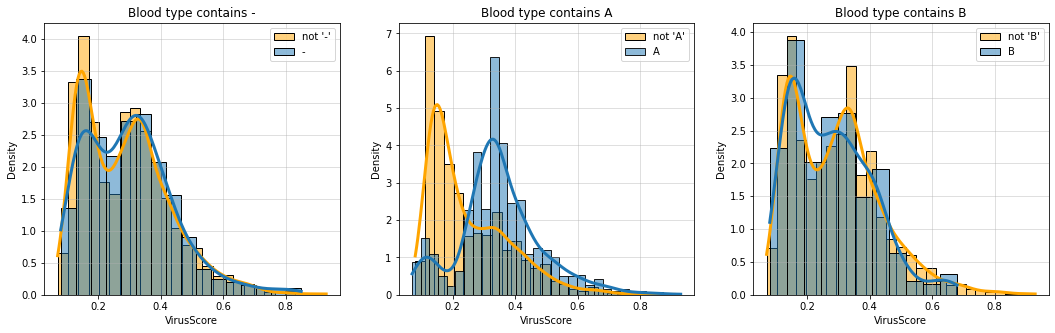

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5)) 
for i, cur_type in enumerate(['blood_-', 'blood_A', 'blood_B']): 
  if cur_type == '-':
    filter_mask = train[cur_type].isin([1])
  else:
    filter_mask = train[cur_type].isin([1]) | train['blood_AB'].isin([1])
  sns.histplot(data=train[~filter_mask].VirusScore, ax=ax[i], stat="density", kde=True, 
               line_kws={"linewidth": 3}, color="orange", label="not '{}'".format(cur_type[-1])) 
  sns.histplot(data=train[filter_mask].VirusScore, ax=ax[i], stat="density", kde=True, 
               line_kws={"linewidth": 3}, label=cur_type[-1]) 
  ax[i].set_title("Blood type contains " + cur_type[-1]) 
  ax[i].legend(), ax[i].grid(alpha=0.5)

**<u>Task</u>:** On both the train and test sets, create a binary feature for the chosen condition (`1` if it is `True` and `0` if `False`) and drop the `BloodType` feature.

In [11]:
from prepare2 import prepare_data

In [12]:
train_dirty, test_dirty = train_test_split(dataset, test_size=0.2, random_state=10)
train_dirty.reset_index(inplace=True)
test_dirty.reset_index(inplace=True)
train = prepare_data(train_dirty, train_dirty) 
test = prepare_data(test_dirty, train_dirty)

#<u>**Section 2: Linear regression implementation**</u>

In [13]:
class LinearRegressor(BaseEstimator, RegressorMixin):
    """
    Custom linear regression model.
    """

    def __init__(self, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param lr: the SGD learning rate (step size)
        """
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.zeros(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w: np.ndarray, b: float, X: np.ndarray, y: np.ndarray) -> float:
        """
        Compute the MSE objective loss.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the linear regression objective loss (float scalar)
        """
        m = X.shape[0]
        loss = (np.linalg.norm(X.dot(w) + b - y)**2)/m
        return loss

    @staticmethod
    def gradient(w: np.ndarray, b: float, X: np.ndarray, y: np.ndarray):
        """
        Compute the (analytical) linear regression objective gradient.

        :param w: weight vector for linear regression; array of shape (n_features,)
        :param b: bias scalar for linear regression
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        margin = X@w + b - y
        g_w = (X.transpose() @ margin) * (2 / X.shape[0])
        g_b = (np.ones(X.shape[0]).transpose() @ margin) * (2 / X.shape[0])
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                      X_val=None, y_val=None):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses: should compute the train & val losses during training?
        :param X_val: validation samples to compute the loss for (for logs only)
        :param y_val: validation labels to compute the loss for (for logs only)
        :return: training and validation losses during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        train_losses = []
        val_losses = []

        if keep_losses:
            train_losses.append(self.loss(self.w, self.b, X, y))
            val_losses.append(self.loss(self.w, self.b, X_val, y_val))

        # Iterate over batches (SGD)
        for itr in range(0, max_iter):
            start_idx = (itr * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # Compute the gradient for the current *batch*
            g_w, g_b = type(self).gradient(self.w, self.b, batch_X, batch_y)

            # Perform a gradient step
            # update the learned parameters correctly
            self.w = self.w - self.lr*g_w
            self.b = self.b - self.lr*g_b

            if keep_losses:
                train_losses.append(self.loss(self.w, self.b,  X, y))
                val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

        return train_losses, val_losses

    def fit(self, X, y, max_iter: int = 1000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Regress labels on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
        """
        # Compute
        y_pred = X.dot(self.w) + self.b

        return y_pred


In [14]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


In [15]:
sub_train, validation = train_test_split(train, test_size=0.2, random_state=10)
sub_train = sub_train.reset_index().drop(labels='index', axis=1)
validation = validation.reset_index().drop(labels='index', axis=1)

##**<u>Q4:</u>**

Using the <u>**normalized**</u> dataset and `VirusScore` as our target, generate a plot that compares the numerical gradients to the analytic gradients.</br>
Do this by running the following command:</br>


> `compare_gradients(X_train, y_train, deltas=np.logspace(-7, -2, 9))`

**Important**: X_train should hold the features of your normalized training subset.</br>
y_train should hold the VirusScore subset training labels.</br></br>
**In your report**: Attach the resulting plots. Briefly discuss and <u>justify</u> the demonstrated behavior.

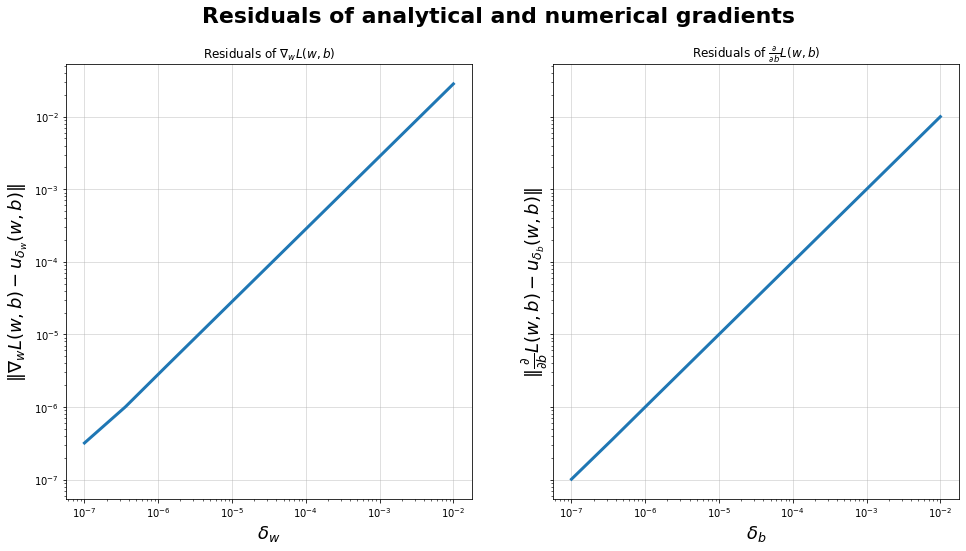

In [16]:
compare_gradients(sub_train.drop('VirusScore', axis=1), sub_train.VirusScore, deltas=np.logspace(-7, -2, 10))

##**<u>Q5:</u>**

In this question, we want to evaluate the effects of different learning rates on the learning procedure. Run the following command that plots a graph of the training and validation losses as a function of the iteration number for different learning rates.
>  `test_lr(X_train, y_train, X_val, y_val)`

**Important**: `X_val` should hold the features of your **<u>normalized</u>** validation subset.</br>
`y_val` should hold the `VirusScore` subset validation labels.
</br></br>
**Note**: If your model did not converge with any learning rate, you are allowed to alter the lr_list variable (but explain this in your report).
</br></br>
Attach the plots to your report, briefly discuss the results and justify the demonstrated behaviors.

In [17]:
def test_lr(X_train, y_train, X_val, y_val, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5)
  
  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

lr size = 1e-09, Best train loss = 0.10333441284986683, Best validation loss = 0.10501411166055583
lr size = 1e-08, Best train loss = 0.1033263164123627, Best validation loss = 0.10500611701112844
lr size = 1e-07, Best train loss = 0.10324539297903707, Best validation loss = 0.10492621065461606
lr size = 1e-06, Best train loss = 0.10244023887144746, Best validation loss = 0.10413114724258048
lr size = 1e-05, Best train loss = 0.09478312489121313, Best validation loss = 0.096567246997324
lr size = 0.0001, Best train loss = 0.04695005054325617, Best validation loss = 0.049139011275594974
lr size = 0.001, Best train loss = 0.013182721519587893, Best validation loss = 0.014434566324702287
lr size = 0.01, Best train loss = 0.008735962566069462, Best validation loss = 0.008451828315450135
lr size = 0.1, Best train loss = 0.00870462489932178, Best validation loss = 0.008165209531237717


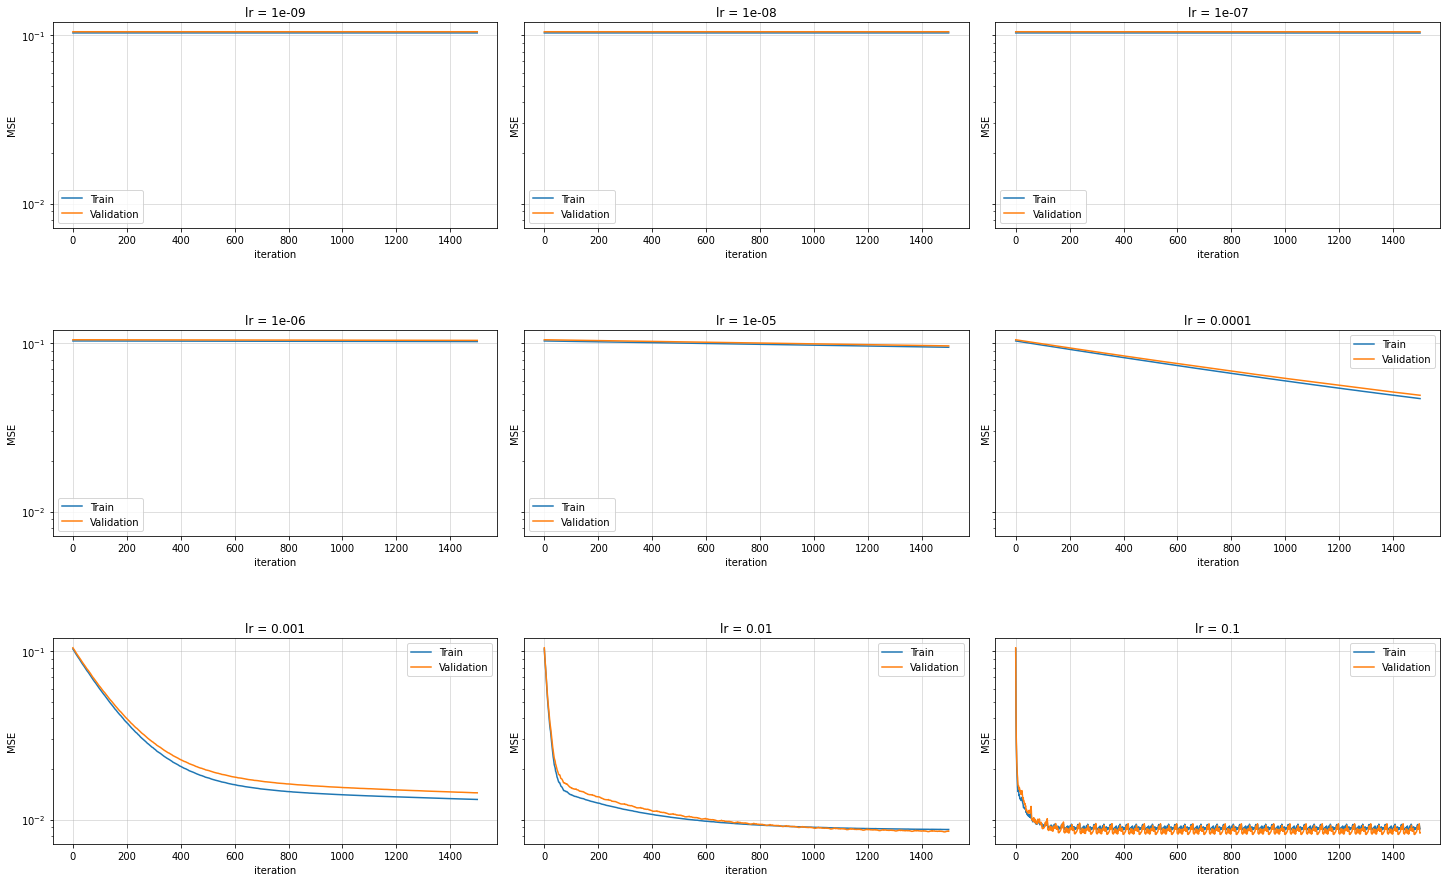

In [18]:
test_lr(sub_train.drop('VirusScore', axis=1), sub_train.VirusScore, validation.drop('VirusScore', axis=1), validation.VirusScore)

#<u>**Section 3: Evaluation and Baseline**</u>

We now train a simple `DummyRegressor` that always predicts the average `VirusScore` of the training set. We will use this regressor throughout the assignment as a baseline to which we will compare the performance of our learned regressors.

##**<u>Q6:</u>**

Create a `DummyRegressor`. Evaluate its performance using `cross-validation`.

In [19]:
clf = DummyRegressor(strategy='mean')
res = cross_validate(clf, X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore), cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, return_train_score = True)
dummy_val_error = res['test_score'].mean()
dummy_train_error = res['train_score'].mean()

model_table = pd.DataFrame({
    'Model': ['Dummy'],
    'Section': [3],
    'Train MSE': [dummy_train_error],
    'Valid MSE': [dummy_val_error]
})
model_table.style.set_caption("Models Scoring Table").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '20px'),
        ('font-weight', 'bold')
    ]
}])

,Model,Section,Train MSE,Valid MSE
0,Dummy,3,-0.019663,-0.019716


**<u>Task</u>**: Retrain the dummy regressor on the entire training set and save it for future use (Sec 7).

In [20]:
section_to_clf = dict()

In [21]:
curr_section = 3
dummy_clf = DummyRegressor(strategy='mean')
_ = dummy_clf.fit(X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore))

section_to_clf[curr_section] = dummy_clf

#<u>**Section 4: Ridge linear regression**</u>

We will now learn to predict `VirusScore` using the `sklearn.linear_model.Ridge` regressor.

##**<u>Q7:</u>**

Tune the regularization strength of the regressor. Remember to attach the required plot and specify the optimal strength with its validation error.

In [22]:
val_scores = dict()
train_scores = dict()

for a in np.logspace(-3, 22, 30, base=2.0):
  res = cross_validate(Ridge(alpha=a, fit_intercept=True), X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore), cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, return_train_score = True)
  val_scores[a] = res['test_score'].mean()
  train_scores[a] = res['train_score'].mean()

to_plot = pd.DataFrame(data={'alpha': train_scores.keys(), 
                             'Validation Error': [val for _, val in val_scores.items()], 
                             'Training Error': [val for _, val in train_scores.items()],
                             'Dummy Validation Error': [dummy_val_error for _ in train_scores.keys()]
                             })
to_plot

,alpha,Validation Error,Training Error,Dummy Validation Error
0,1.250000e-01,-0.008767,-0.008528,-0.019716
1,2.272054e-01,-0.008767,-0.008528,-0.019716
2,4.129783e-01,-0.008767,-0.008528,-0.019716
3,7.506472e-01,-0.008766,-0.008529,-0.019716
4,1.364409e+00,-0.008766,-0.008529,-0.019716
5,2.480008e+00,-0.008766,-0.008531,-0.019716
6,4.507770e+00,-0.008770,-0.008536,-0.019716
7,8.193516e+00,-0.008782,-0.008553,-0.019716
8,1.489289e+01,-0.008825,-0.008601,-0.019716
9,2.706996e+01,-0.008952,-0.008736,-0.019716


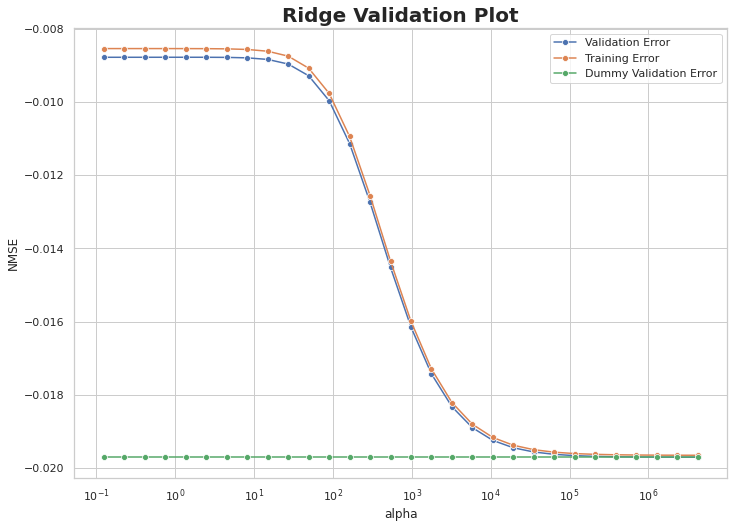

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(x="alpha", y="Validation Error", data=to_plot,
                 ci=None, label='Validation Error', marker='o')
sns.lineplot(x="alpha", y="Training Error", data=to_plot,
                 ci=None, label='Training Error', marker='o', ax=ax1)
sns.lineplot(x="alpha", y="Dummy Validation Error", data=to_plot,
                 ci=None, label='Dummy Validation Error', marker='o', ax=ax1)
ax1.set(xlabel='alpha', ylabel='NMSE', xscale='log')
ax1.legend()
_ = plt.title('Ridge Validation Plot', fontsize=20, fontweight='bold')

##**<u>Q8:</u>**

Fill in the cross-validated errors of the regressor yielded by the optimal hyperparameter.

In [24]:
model_table.loc[1] = ['Ridge Linear', 4, -0.008531, -0.008766]
model_table.style.set_caption("Models Scoring Table").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '20px'),
        ('font-weight', 'bold')
    ]
}])

,Model,Section,Train MSE,Valid MSE
0,Dummy,3,-0.019663,-0.019716
1,Ridge Linear,4,-0.008531,-0.008766


**<u>Task:</u>** Using the best performing hyperparameter, retrain a regressor on the entire training set.</br>
Save this regressor for future use (Section 7).

In [25]:
curr_section = 4
ridge_clf = Ridge(alpha=2.5, fit_intercept=True)
_ = ridge_clf.fit(X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore))

section_to_clf[curr_section] = ridge_clf

##**<u>Q9:</u>**

Specify the 5 features that have the 5 largest coefficients (in absolute value) in the resulting regressor, from the largest to the smallest (among these 5).

In [26]:
feature_coefs = sorted(list(zip(train.drop(labels='VirusScore', axis=1).columns, np.absolute(ridge_clf.coef_))), key=lambda x: x[1], reverse=True)
print("\033[4m\033[1mThe coefficients of the features from largest to smallest:\033[0m")
for feature, coef in feature_coefs:
  print(f'\033[1m{feature}:\033[0m {coef}')

The coefficients of the features from largest to smallest:
shortness_of_breath: 0.25887465678791644
num_of_siblings: 0.15561022255624363
fever: 0.11542230321121387
contains_blood_A: 0.09457584995729523
household_income: 0.030380317894939637
zip_code: 0.01620172270075469
PCR_07: 0.003617006265658036
PCR_05: 0.003260396535083862
PCR_06: 0.0031264542474240967
PCR_10: 0.0028959028733881753
PCR_03: 0.0009280351095471551
sugar_levels: 0.0006671848500400293
PCR_02: 0.0005088109922342207
PCR_01: 0.0003920636010345482


##**<u>Q10:</u>**

Sort and plot the absolute values of the learned coefficients. The x-axis should be the index of the parameter from largest to smallest.

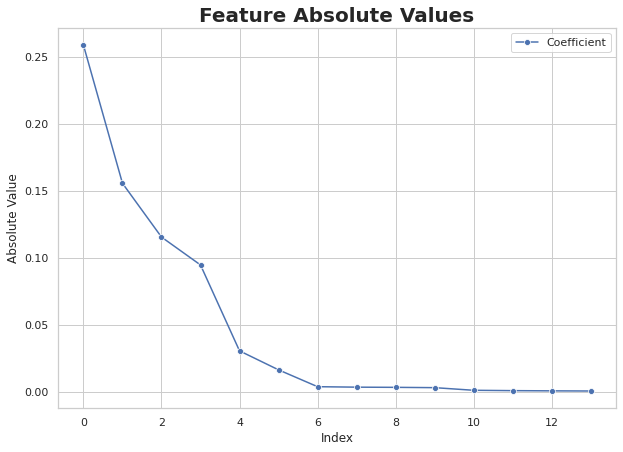

In [27]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(data=np.array([coef for _, coef in feature_coefs]),
                 ci=None, label='Coefficient', marker='o')
ax1.set(xlabel='Index', ylabel='Absolute Value')
ax1.legend()
_ = plt.title('Feature Absolute Values', fontsize=20, fontweight='bold')

#<u>**Section 5: Lasso linear regression**</u>

In this section, follow the same instructions as in the previous section, with one difference – instead of the `Ridge` regressor, use the `sklearn.linear_model.Lasso` regressor.

##**<u>Q11:</u>**

Tune the regularization strength of the regressor.</br>
Remember to attach the required plot and the optimal strength with its validation error.

In [28]:
val_scores = dict()
train_scores = dict()

for a in np.logspace(-13, 0, 30, base=2.0):
  res = cross_validate(Lasso(alpha=a, fit_intercept=True), X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore), cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, return_train_score = True)
  val_scores[a] = res['test_score'].mean()
  train_scores[a] = res['train_score'].mean()

to_plot = pd.DataFrame(data={'alpha': train_scores.keys(), 
                             'Validation Error': [val for _, val in val_scores.items()], 
                             'Training Error': [val for _, val in train_scores.items()],
                             'Dummy Validation Error': [dummy_val_error for _ in train_scores.keys()]
                             })
to_plot

,alpha,Validation Error,Training Error,Dummy Validation Error
0,0.000122,-0.008766,-0.008530,-0.019716
1,0.000167,-0.008766,-0.008531,-0.019716
2,0.000227,-0.008766,-0.008533,-0.019716
3,0.000310,-0.008768,-0.008537,-0.019716
4,0.000423,-0.008772,-0.008544,-0.019716
5,0.000577,-0.008780,-0.008557,-0.019716
6,0.000788,-0.008796,-0.008581,-0.019716
7,0.001075,-0.008829,-0.008625,-0.019716
8,0.001466,-0.008883,-0.008694,-0.019716
9,0.002000,-0.008973,-0.008802,-0.019716


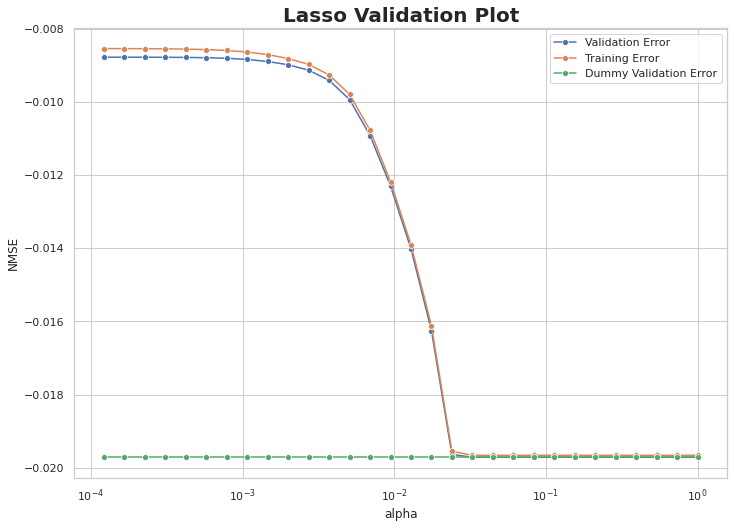

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(x="alpha", y="Validation Error", data=to_plot,
                 ci=None, label='Validation Error', marker='o')
sns.lineplot(x="alpha", y="Training Error", data=to_plot,
                 ci=None, label='Training Error', marker='o', ax=ax1)
sns.lineplot(x="alpha", y="Dummy Validation Error", data=to_plot,
                 ci=None, label='Dummy Validation Error', marker='o', ax=ax1)
ax1.set(xlabel='alpha', ylabel='NMSE', xscale='log')
ax1.legend()
_ = plt.title('Lasso Validation Plot', fontsize=20, fontweight='bold')

##**<u>Q13:</u>**

Fill in the cross-validated errors of the regressor yielded by the optimal hyperparameter.

In [30]:
model_table.loc[2] = ['Lasso Linear', 5, -0.008533, -0.008766]
model_table.style.set_caption("Models Scoring Table").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '20px'),
        ('font-weight', 'bold')
    ]
}])

,Model,Section,Train MSE,Valid MSE
0,Dummy,3,-0.019663,-0.019716
1,Ridge Linear,4,-0.008531,-0.008766
2,Lasso Linear,5,-0.008533,-0.008766


<u>**Task:**</u> Using the best performing hyperparameter, retrain a regressor on the entire training set.

In [31]:
curr_section = 5
lasso_clf = Ridge(alpha=2.27e-4, fit_intercept=True)
_ = lasso_clf.fit(X=np.array(train.drop(labels='VirusScore', axis=1)), y = np.array(train.VirusScore))

section_to_clf[curr_section] = lasso_clf

##**<u>Q14:</u>**

Specify the 5 features that have the 5 largest coefficients (in absolute value) in the resulting regressor, from the largest to the smallest (among these 5).

In [32]:
feature_coefs = sorted(list(zip(train.drop(labels='VirusScore', axis=1).columns, np.absolute(lasso_clf.coef_))), key=lambda x: x[1], reverse=True)
print("\033[4m\033[1mThe coefficients of the features from largest to smallest:\033[0m")
for feature, coef in feature_coefs:
  print(f'\033[1m{feature}:\033[0m {coef}')

The coefficients of the features from largest to smallest:
shortness_of_breath: 0.2620253273463006
num_of_siblings: 0.15874226253058982
fever: 0.11657430547502849
contains_blood_A: 0.09492893980005508
household_income: 0.031059790274202213
zip_code: 0.016563435712460817
PCR_07: 0.0035999166075011044
PCR_05: 0.00326836985292221
PCR_06: 0.0031333719878013804
PCR_10: 0.0028652693184266415
PCR_03: 0.0008893590127853154
sugar_levels: 0.0006598553963646599
PCR_02: 0.0004704117462488701
PCR_01: 0.00041313543454993794


##**<u>Q15:</u>**

Again, sort and plot the absolute value of the learned coefficients. The x-axis should be the index of the parameter from largest to smallest.</br>
Compare the coefficients obtained here to the ones of the Ridge regressor from (Q10).

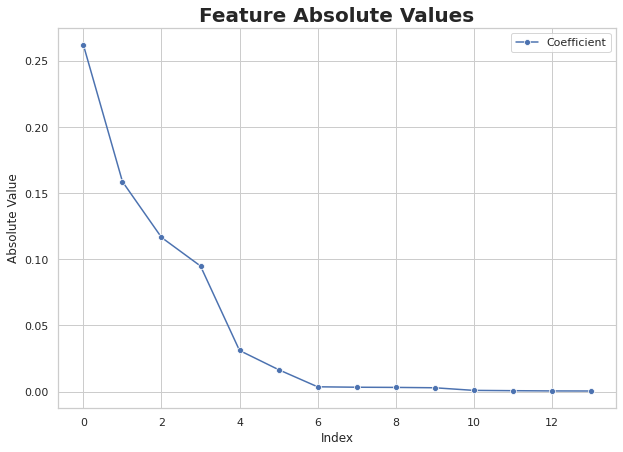

In [33]:
sns.set(rc={'figure.figsize':(10,7)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(data=np.array([coef for _, coef in feature_coefs]),
                 ci=None, label='Coefficient', marker='o')
ax1.set(xlabel='Index', ylabel='Absolute Value')
ax1.legend()
_ = plt.title('Feature Absolute Values', fontsize=20, fontweight='bold')

#<u>**Section 6: Polynomial fitting**</u>

<u>**Task:**</u> Create copies of your train and test sets. Add 2nd-degree polynomial features (`degree=2, include_bias=False`).

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_train = poly.fit_transform(X=train.drop(labels='VirusScore', axis=1))
poly_test = poly.fit_transform(X=test.drop(labels='VirusScore', axis=1))
poly_train.shape

(2400, 119)

##**<u>Q18:</u>**

Tune the regularization strength of a Ridge regressor (with the polynomial mapping).
Remember to attach required plots, optimal strengths, optimal validation errors.

In [35]:
val_scores = dict()
train_scores = dict()

for a in np.logspace(-3, 22, 30, base=2.0):
  res = cross_validate(Ridge(alpha=a, fit_intercept=True), X=poly_train, y = np.array(train.VirusScore), cv = 5, scoring='neg_mean_squared_error', n_jobs = -1, return_train_score = True)
  val_scores[a] = res['test_score'].mean()
  train_scores[a] = res['train_score'].mean()
  
to_plot = pd.DataFrame(data={'alpha': train_scores.keys(), 
                             'Validation Error': [val for _, val in val_scores.items()], 
                             'Training Error': [val for _, val in train_scores.items()],
                             'Dummy Validation Error': [dummy_val_error for _ in train_scores.keys()]
                             })
to_plot

,alpha,Validation Error,Training Error,Dummy Validation Error
0,1.250000e-01,-0.008066,-0.006883,-0.019716
1,2.272054e-01,-0.008061,-0.006883,-0.019716
2,4.129783e-01,-0.008052,-0.006883,-0.019716
3,7.506472e-01,-0.008039,-0.006885,-0.019716
4,1.364409e+00,-0.008020,-0.006889,-0.019716
5,2.480008e+00,-0.007996,-0.006900,-0.019716
6,4.507770e+00,-0.007976,-0.006925,-0.019716
7,8.193516e+00,-0.007973,-0.006977,-0.019716
8,1.489289e+01,-0.008014,-0.007078,-0.019716
9,2.706996e+01,-0.008137,-0.007263,-0.019716


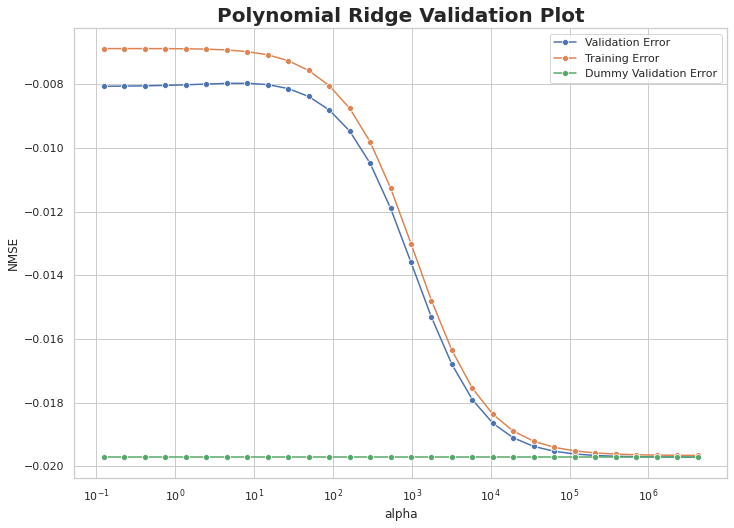

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
ax1 = sns.lineplot(x="alpha", y="Validation Error", data=to_plot,
                 ci=None, label='Validation Error', marker='o')
sns.lineplot(x="alpha", y="Training Error", data=to_plot,
                 ci=None, label='Training Error', marker='o', ax=ax1)
sns.lineplot(x="alpha", y="Dummy Validation Error", data=to_plot,
                 ci=None, label='Dummy Validation Error', marker='o', ax=ax1)
ax1.set(xlabel='alpha', ylabel='NMSE', xscale='log')
ax1.legend()
_ = plt.title('Polynomial Ridge Validation Plot', fontsize=20, fontweight='bold')

##**<u>Q19:</u>**

Fill in the train and validation errors of the regressor yielded by the best performing hyperparameter.

In [37]:
model_table.loc[3] = ['Ridge Polynomial', 6, -0.006977, -0.007973]
model_table.style.set_caption("Models Scoring Table").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '20px'),
        ('font-weight', 'bold')
    ]
}])

,Model,Section,Train MSE,Valid MSE
0,Dummy,3,-0.019663,-0.019716
1,Ridge Linear,4,-0.008531,-0.008766
2,Lasso Linear,5,-0.008533,-0.008766
3,Ridge Polynomial,6,-0.006977,-0.007973


<u>**Task:**</u> Train the polynomial regressor on the entire training set and save it for future use (Sec 7).

In [38]:
curr_section = 6
poly_ridge_clf = Ridge(alpha=8.193516, fit_intercept=True)
_ = poly_ridge_clf.fit(X=poly_train, y = np.array(train.VirusScore))

section_to_clf[curr_section] = poly_ridge_clf

#<u>**Section 7: Testing your models**</u>

Finally, we can let the test set come out and play.</br>
At the end of the previous sections, you retrained the tuned models on the entire training set. You will now evaluate the test errors (MSE) for those 3 models, as well as the Dummy baseline.

##**<u>Q20:</u>**

Complete the entire table.</br>
Which model performed best on the test set?</br>
Discuss the results in the table (from an overfitting and underfitting perspective, or any other insightful perspective).

In [39]:
test_res = list()

for i in range(model_table.shape[0]):
  section = model_table.loc[i, 'Section']
  y_hat = section_to_clf[section].predict(X=(np.array(test.drop(labels='VirusScore', axis=1)) if i < model_table.shape[0] - 1 else poly_test))
  nmse = -((y_hat - test.VirusScore)**2).mean()
  test_res.append(nmse)

if 'Test MSE' in model_table:
  del model_table['Test MSE']
model_table.insert(4, column='Test MSE', value=test_res)
model_table.style.set_caption("Models Scoring Table").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '20px'),
        ('font-weight', 'bold')
    ]
}])

,Model,Section,Train MSE,Valid MSE,Test MSE
0,Dummy,3,-0.019663,-0.019716,-0.022810
1,Ridge Linear,4,-0.008531,-0.008766,-0.009272
2,Lasso Linear,5,-0.008533,-0.008766,-0.009251
3,Ridge Polynomial,6,-0.006977,-0.007973,-0.008800


#<u>**Section 9: Submitted model predictions**</u>

For each model you implemented, you should submit a single CSV file containing your predictions on the unlabeled dataset `virus_unlabeled.csv`.</br>
Notice that this unseen dataset requires the same <u>preparation</u> as the rest of your data.</br></br>
Before performing any predictions, train each of your models on the <u>**entire labeled dataset at your disposal**</u>, including the labeled test set.</br></br>
For each relevant section, submit a file named **`pred_<sect_num>.csv`**.</br>
Each file should consist of an “patient_id” column and a “VirusScore” column.</br>
Every row should have the original ID of the predicted input and the prediction of the best regressor you found in the appropriate section.</br></br>

Example for a prediction file (actual file should have 1001 rows including the headers):

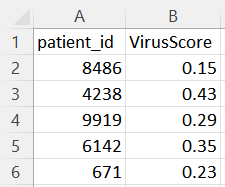

First we will retrain the models on the entire dataset.

In [47]:
train = prepare_data(dataset, dataset)

In [48]:
for section, clf in section_to_clf.items():
  if section == 6: # Polynomial Ridge Regression:
    poly_train = poly.fit_transform(X=train.drop(labels='VirusScore', axis=1))
    clf.fit(X=poly_train, y=np.array(train.VirusScore))
  else:
    clf.fit(X=np.array(train.drop(labels='VirusScore', axis=1)), y=np.array(train.VirusScore))

Create a function to automate the dataframe creation process.

In [49]:
def classifiers_to_dfs(clf_dict: Dict[int, BaseEstimator], test_data: pd.DataFrame) -> Dict[int, pd.DataFrame]:
  res = dict()
  test_copy = test_data.copy()
  test_X = np.array(test_copy) if 'patient_id' not in test_copy.columns else np.array(test_copy.drop(labels='patient_id', axis=1))
  for key, clf in clf_dict.items():
    test_copy.loc[:,'VirusScore'] = clf.predict(X=(test_X if key != 6 else poly.fit_transform(X=test_X)))
    res[key] = pd.DataFrame(data=test_copy[['patient_id', 'VirusScore']])
  return res

We will now reload the test data into a dataframe that will also contain the `patient_id` feature.

In [50]:
filename = '/content/gdrive/MyDrive/Technion/Machine Learning/Major HW 3/virus_unlabeled.csv'
unlabeled_dataset = pd.read_csv(filename)
test_with_id = prepare_data(unlabeled_dataset, dataset, drop_id=False)

test_with_id.head()

,patient_id,zip_code,contains_blood_A,household_income,num_of_siblings,shortness_of_breath,fever,sugar_levels,PCR_01,PCR_02,PCR_03,PCR_05,PCR_06,PCR_07,PCR_10
0,8486,0.335575,0,0.492223,0.333333,0.0,0.0,-0.518649,1.148224,-0.956074,-0.105080,1.649458,1.389241,-0.952378,0.701564
1,4238,0.470668,0,0.610709,0.166667,0.0,0.0,0.247430,-0.717399,-0.401407,-0.632707,-1.693285,-1.590009,0.668248,0.701564
2,9919,0.647556,1,0.446063,0.500000,0.0,0.0,-0.737528,-0.524236,1.145071,0.831747,1.649458,1.374541,0.401377,0.701564
3,6142,0.988838,0,0.187155,0.333333,0.0,0.0,1.943747,0.748622,-0.386932,-0.077672,-0.021914,0.173281,-0.602967,-0.054703
4,671,0.942466,0,0.142480,0.166667,1.0,0.0,-0.573368,0.452987,-0.586422,-0.191965,1.092334,0.960401,-0.378163,-1.567238


Predict the `VirusScore` targets and aggragate them into the corresponding dataframes:

In [51]:
section_to_df = classifiers_to_dfs(section_to_clf, test_with_id)

for section, df in section_to_df.items():
  print(f'The dataframe for section {section}:\n{df.head()}\n\n')

The dataframe for section 3:
   patient_id  VirusScore
0        8486    0.292333
1        4238    0.292333
2        9919    0.292333
3        6142    0.292333
4         671    0.292333


The dataframe for section 4:
   patient_id  VirusScore
0        8486    0.208492
1        4238    0.185225
2        9919    0.329737
3        6142    0.209574
4         671    0.450058


The dataframe for section 5:
   patient_id  VirusScore
0        8486    0.207950
1        4238    0.184091
2        9919    0.329841
3        6142    0.209110
4         671    0.451725


The dataframe for section 6:
   patient_id  VirusScore
0        8486    0.207701
1        4238    0.185394
2        9919    0.338914
3        6142    0.191210
4         671    0.424570




Finally, download the output `.csv` files.

In [55]:
# from google.colab import files

# for section, df in section_to_df.items():
#   if section == 3:
#     continue
#   output_path = f'pred_{section}.csv'
#   df.to_csv(output_path, index=False)
#   files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>